In [27]:
from source.algorithm import GraphWrapper
from pathlib import Path
from tqdm import tqdm

data_path = Path('F:\\data')

input_path = data_path / 'benign_graphs' / 'tc3-theia' / 'firefox' / 'nd'
input_paths = random.choices(list(input_path.glob('*.json')), k=400)
input_graphs = [GraphWrapper(input_path) 
                for input_path in tqdm(input_paths, desc='Reading graphs')]
len(input_graphs)

Reading graphs: 100%|██████████| 400/400 [00:16<00:00, 24.64it/s]


400

In [94]:
from collections import deque
from source.algorithm import GraphWrapper, EdgeWrapper, NodeWrapper, Subgraph, IN, OUT

def get_subgraphs(graph: GraphWrapper, direction: str) -> list[Subgraph]:
    result: list[Subgraph] = []
    visited_edges: set[EdgeWrapper] = set()

    queue = deque([(0, graph.source_edge_id)])
    while len(queue) > 0:
        # Pop
        depth, edge_id = queue.popleft()
        edge: EdgeWrapper = graph.get_edge(edge_id)
        if edge in visited_edges:
            continue
        visited_edges.add(edge)
        
        # Add subgraph
        result.append(Subgraph(
            parent_graph=graph,
            depth=depth,
            edges=graph.get_subtree(edge_id, direction)
        ))
        
        # Extend queue
        node_id: int = edge.node_ids[direction]
        node: NodeWrapper = graph.get_node(node_id)
        next_edge_ids: list[int] = node.edge_ids[direction]

        queue.extend([(depth + 1, next_edge_id)
                      for next_edge_id in next_edge_ids])
    return result

subgraphs = []
for graph in input_graphs:
    subgraphs.extend(get_subgraphs(graph, IN))
len(subgraphs)

386737

In [29]:
x = [graph.depth for graph in subgraphs]
min(x), max(x)

(0, 8)

In [100]:
from source.algorithm.utility import to_nx
nx_graphs = [to_nx(graph) 
             for graph in tqdm(subgraphs, desc='Converting to NetworkX graphs')]
len(nx_graphs)

Converting to NetworkX graphs: 100%|██████████| 386737/386737 [01:13<00:00, 5291.75it/s] 


386737

In [31]:
from karateclub import Graph2Vec

graph2vec = Graph2Vec(
    wl_iterations=80,
    attributed=True,
    dimensions=128,
    workers=4,
    epochs=5
)

graph2vec.fit(nx_graphs)

graph2vec_embedding = graph2vec.get_embedding()
len(graph2vec_embedding)

386737

# I. Graph2Vec Embedding Analysis

## A. Embedding Variance
The embedding is not deterministic - it varies every time it is computed. 

TODO: look into how the graph2vec.embeddings() works.

compare embedding from graph2vec.embeddings() with graph2vec.infer(graph) - mean .97ish, std around .02 


In [84]:
import random

import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

indices = list(range(len(nx_graphs)))
sample_indices = random.choices(indices, k=20000)
columns = ['index', 'embedding_i', 'inferred_i', 'cosine_similarity']
df = pd.DataFrame(columns=columns)

for i in tqdm(sample_indices):
    graph = subgraphs[i]
    row = {
        'index': i,
        'depth': graph.depth,
        '#edges': len(graph.edges),
        '#nodes': len(graph.nodes),
        'embedding_i': graph2vec_embedding[i],
        'inferred_i': graph2vec.infer([nx_graphs[i]])[0],
        'cosine_similarity': cosine_similarity([graph2vec_embedding[i]], [graph2vec.infer([nx_graphs[i]])[0]])[0, 0]
    }
    df = df.append([row], ignore_index=True)

 34%|███▍      | 33872/100000 [03:10<06:10, 178.26it/s]


KeyboardInterrupt: 

In [ ]:
df['#edges'] = df['index'].apply(lambda i: len(subgraphs[i].edges))

In [83]:
# group df by #edges
grouped_data = df.groupby('#edges')['cosine_similarity'].agg(['mean', 'std', 'count'])
grouped_data

,mean,std,count
#edges,,,
1.0,0.971427,0.020596,9878
2.0,0.976955,0.023588,20
3.0,0.956525,0.024739,5
4.0,0.974760,0.003769,5
5.0,0.963782,NaN,1
7.0,0.979989,0.005538,4
17.0,0.987531,NaN,1
22.0,0.966198,NaN,1
25.0,0.980197,NaN,1


In [53]:
np.std(similarities)

0.020014646

In [ ]:
import pickle
with open('graph2vec_embedding.p', 'wb') as f:
    pickle.dump(graph2vec_embedding, f)
with open('subgraphs.p', 'wb') as f:
    pickle.dump(subgraphs, f)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

data = {
    'delta_depth': [],
    'depth_1': [],
    'depth_2': [],
    'cosine_similarity': [],
    'parent_graph': []
}

graph_ids = list(set([s.graph.source_edge_id for s in subgraphs]))[:5]
for i_g, graph_id in enumerate(graph_ids):
    contained_subgraphs = [(i, s) for i, s in enumerate(subgraphs) if s.graph.source_edge_id == graph_id]
    comparisons = list(combinations(contained_subgraphs, 2))
    for (i, s1), (j, s2) in tqdm(comparisons, desc=f'{i_g+1}/{len(graph_ids)} ({graph_id})'):
        data['depth_1'].append(s1.depth)
        data['depth_2'].append(s2.depth)
        data['cosine_similarity'].append(cosine_similarity([graph2vec_embedding[i]], [graph2vec_embedding[j]])[0][0])


4/5: 100%|██████████| 500500/500500 [01:23<00:00, 5969.79it/s]


## Similarity between paths

In [148]:
import random
from sklearn.metrics.pairwise import cosine_similarity
from algorithm.utility import to_nx

paths: list[list[EdgeWrapper]] = []
nx_path_graphs = []
def generate_path(graph: GraphWrapper, edge_id: int, direction: str) -> list[EdgeWrapper]:
    visited: dict[int, bool] = {}
    edges: list[EdgeWrapper] = [graph.get_edge(graph.source_edge_id)]
    current = graph.get_edge(edge_id)
    
    # very ugly loop, it works though... #TODO: refactor
    while current is not None:
        visited[current.get_ref_id()] = True
        edges.append(current)
        node_id = current.node_ids[direction]
        node = graph.get_node(node_id)
    
        next_edge_ids = node.edge_ids[direction]
        if len(next_edge_ids) == 0:
            break
        next_edge_id = random.choice(node.edge_ids[direction])
        current = graph.get_edge(next_edge_id)
    return edges

def generate_path_subgraphs(graph: GraphWrapper, direction: str, n: int) -> list[Subgraph]:
    path_edges: list[list[EdgeWrapper]] = []
    for _ in range(n):
        path_edges.append(generate_path(graph, graph.source_edge_id, direction))
    return [ Subgraph(parent_graph=graph, edges=edges)
             for edges in path_edges ]

nx_path_subgraphs = []

for graph in tqdm(input_graphs):
    nx_path_subgraphs.extend(generate_path_subgraphs(graph, IN, 1000))
    
len(nx_path_subgraphs)

100%|██████████| 400/400 [00:01<00:00, 301.43it/s]


400000

In [149]:
lengths = [len(x.edges) for x in nx_path_subgraphs ]
min(lengths), max(lengths)

(3, 20)

In [34]:
import numpy as np
np.std(lengths)

0.10074937480420348

In [152]:
candidates = [g for g in nx_path_subgraphs if len(g.edges) > 3]
len(candidates)

15648

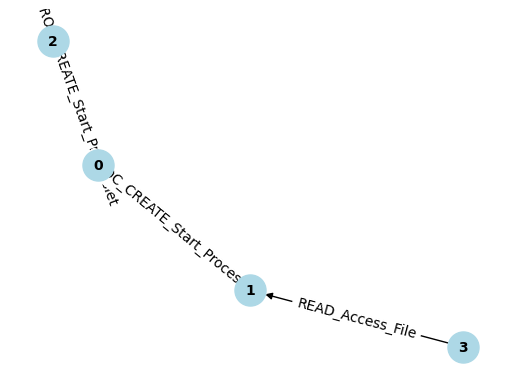

In [153]:
import networkx as nx
import matplotlib.pyplot as plt
G = to_nx(candidates[0])
# Draw the graph
fig, ax = plt.subplots()  # Create a figure and an axes object\
# Draw the nodes and edges
pos = nx.spring_layout(G)
nx.draw(G, pos,ax=ax, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')

edge_labels = nx.get_edge_attributes(G, 'feature')
node_labels = nx.get_node_attributes(G, 'feature')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)

# Show the plot
plt.show()

In [154]:

def get_subpaths(nx_graph):
    roots = [node for node, in_deg in nx_graph.in_degree() if in_deg == 0]
    assert len(roots) == 1

    root = roots[0]
    paths = nx.single_source_shortest_path(nx_graph, root)
    path_graphs = []
    for target in paths:
        if target != root:
            path = paths[target]
            path_graph = nx.DiGraph(nx_graph.subgraph(path))
            mapping = {old_label: new_label for new_label, old_label in enumerate(path_graph.nodes())}
            
            path_graphs.append(nx.relabel_nodes(path_graph, mapping))

    return path_graphs

path_graphs = get_subpaths(to_nx(candidates[0]))

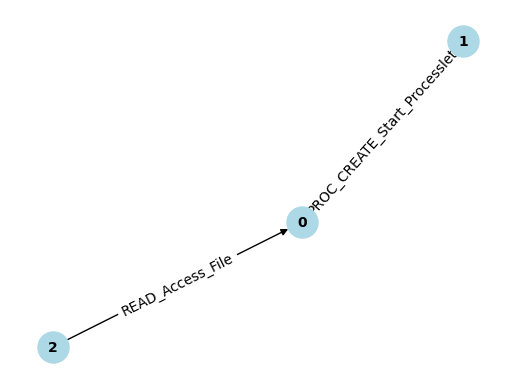

In [144]:
G = to_nx(candidates[1000])
# Draw the graph
fig, ax = plt.subplots()  # Create a figure and an axes object
# Draw the nodes and edges
pos = nx.spring_layout(G)
nx.draw(G, pos,ax=ax, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')

edge_labels = nx.get_edge_attributes(G, 'feature')
node_labels = nx.get_node_attributes(G, 'feature')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)

# Show the plot
plt.show()

In [130]:
path_graphs_list = [get_subpaths(to_nx(c)) for c in candidates]
len(path_graphs_list)

10000

In [201]:

df = pd.DataFrame(columns=['i', 'j', 'length_i', 'length_j', 'similarity'])

In [202]:
import pandas as pd
graphs = []
for c in candidates:
    graphs.extend([sg for sg in get_subpaths(to_nx(c))])

N = len(candidates)
for _ in tqdm(range(20000)):
    # why...
    random.seed(None)
    i = random.randint(0, N-1)
    random.seed(None)
    j = random.randint(0, N-1)
    g_i, g_j = graphs[i], graphs[j]

    e_i = graph2vec.infer([g_i])
    e_j = graph2vec.infer([g_j])

    row = {
        'i': i,
        'j': j,
        'length_i': len(g_i.edges),
        'length_j': len(g_j.edges),
        'similarity': cosine_similarity(e_i, e_j)[0,0]        
    }
    df = df.append(row, ignore_index=True)
df.head()

100%|██████████| 20000/20000 [01:36<00:00, 207.69it/s]


,i,j,length_i,length_j,similarity
0,7687.0,7559.0,3.0,5.0,0.404218
1,3351.0,9080.0,3.0,3.0,0.580845
2,10803.0,4568.0,7.0,7.0,0.409879
3,7591.0,1735.0,3.0,9.0,0.187810
4,9065.0,9327.0,3.0,3.0,0.638624


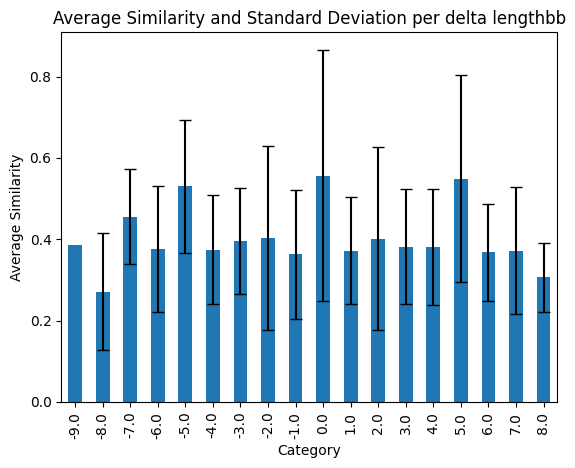

In [203]:
df['delta_length'] = df['length_i'] - df['length_j']
graph_data = df.groupby('delta_length')['similarity']
mean = graph_data.mean()
std_dev =graph_data.std()
fig, ax = plt.subplots()
mean.plot(kind='bar', yerr=std_dev, ax=ax, capsize=4)
ax.set_xlabel('Category')
ax.set_ylabel('Average Similarity')
ax.set_title('Average Similarity and Standard Deviation per delta lengthbb')
plt.show()

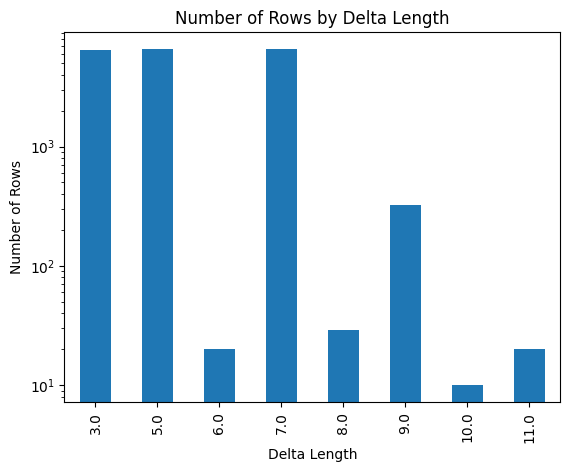

In [207]:
delta_length_counts = df['length_i'].value_counts().sort_index()
delta_length_counts.plot(kind='bar')
plt.xlabel('Delta Length')
plt.ylabel('Number of Rows')
plt.title('Number of Rows by Delta Length')
plt.yscale('log')
plt.show()

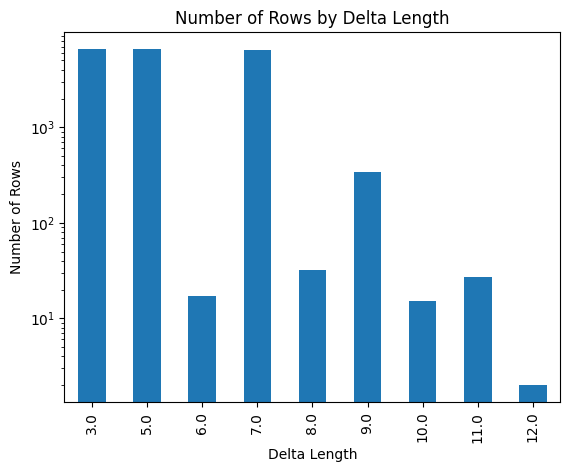

In [206]:
delta_length_counts = df['length_j'].value_counts().sort_index()
delta_length_counts.plot(kind='bar')
plt.xlabel('Delta Length')
plt.ylabel('Number of Rows')
plt.title('Number of Rows by Delta Length')
plt.yscale('log')
plt.show()

In [191]:
%pip install seaborn

   ---------------------------------------- 0.0/294.8 kB ? eta -:--:--
   ---------------------------------------- 294.8/294.8 kB 6.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\Jonathan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


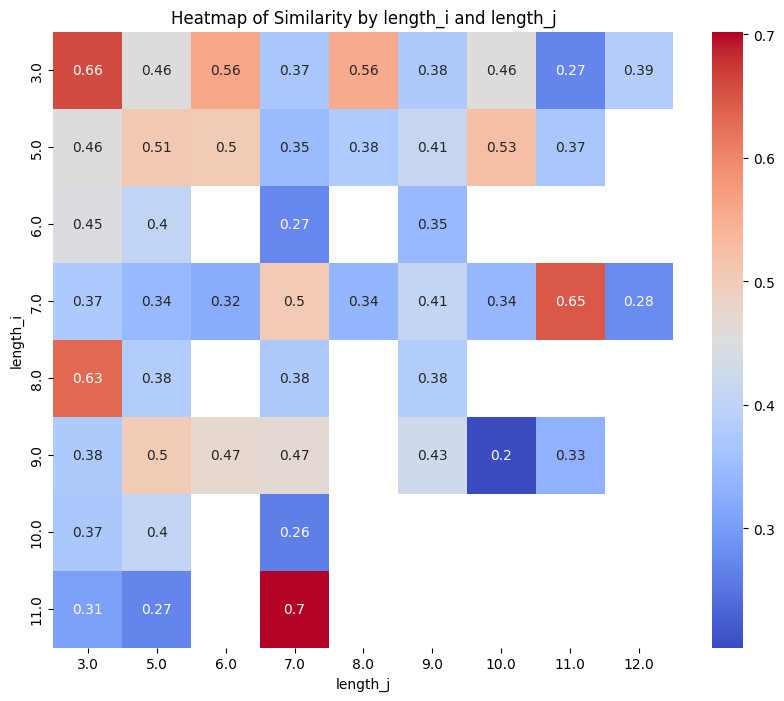

In [205]:
import seaborn as sns
plt.figure(figsize=(10, 8))  # You can adjust the size of the figure
pivot_table = df.pivot_table(index='length_i', columns='length_j', values='similarity', aggfunc='mean')

sns.heatmap(pivot_table, annot=True, cmap='coolwarm')  # 'annot=True' will annotate the cells with similarity values
plt.title('Heatmap of Similarity by length_i and length_j')
plt.xlabel('length_j')
plt.ylabel('length_i')
plt.show()

In [162]:
len(df)

1000

In [156]:
lengths = [len(g.edges) for g in graphs]
np.mean(lengths), np.std(lengths)

(3.074258691206544, 0.3798435833376497)

In [126]:
graphs

In [116]:
for path_graphs in path_graphs_list:
    path_embeddings = graph2vec.infer(path_graphs)
    for i in range(len(path_embeddings)):
        for _ in range(1, i+1):
            print('              ', end='')
        for j in range(i+1, len(path_embeddings)):
            s = cosine_similarity([path_embeddings[i]], [path_embeddings[j]])[0,0]
            print(f'({i}, {j}): {s:.2f}',end='  ')
        print()
    print("===========")

(0, 1): 0.44  (0, 2): 0.26  (0, 3): 0.31  
              (1, 2): 0.17  (1, 3): 0.22  
                            (2, 3): 0.46  
                                          
(0, 1): 0.42  (0, 2): 0.24  (0, 3): 0.33  
              (1, 2): 0.02  (1, 3): 0.19  
                            (2, 3): 0.45  
                                          
(0, 1): 0.49  (0, 2): 0.25  (0, 3): 0.32  
              (1, 2): 0.04  (1, 3): 0.20  
                            (2, 3): 0.45  
                                          
(0, 1): 0.37  (0, 2): 0.24  (0, 3): 0.23  
              (1, 2): 0.03  (1, 3): 0.17  
                            (2, 3): 0.46  
                                          
(0, 1): 0.40  (0, 2): 0.22  (0, 3): 0.20  
              (1, 2): -0.00  (1, 3): 0.18  
                            (2, 3): 0.45  
                                          
(0, 1): 0.48  (0, 2): 0.30  (0, 3): 0.32  
              (1, 2): 0.18  (1, 3): 0.21  
                            (2, 3): 0.47  
          

In [99]:
whole_graphs = [i for i, g in enumerate(subgraphs) if g.depth == 0]
len(whole_graphs)

400

In [103]:

embeddings = graph2vec.get_embedding()


In [108]:
import itertools
comparisons = list(itertools.combinations(list(range(400)), 2))
similarities = []
for i, j in tqdm(comparisons):
    e_i = embeddings[i]
    e_j = embeddings[j]
    similarities.append(cosine_similarity([e_i], [e_j])[0,0])

100%|██████████| 79800/79800 [00:05<00:00, 15497.33it/s]


In [109]:
np.mean(similarities), np.std(similarities)

(0.76340365, 0.1451599)

0.1451599